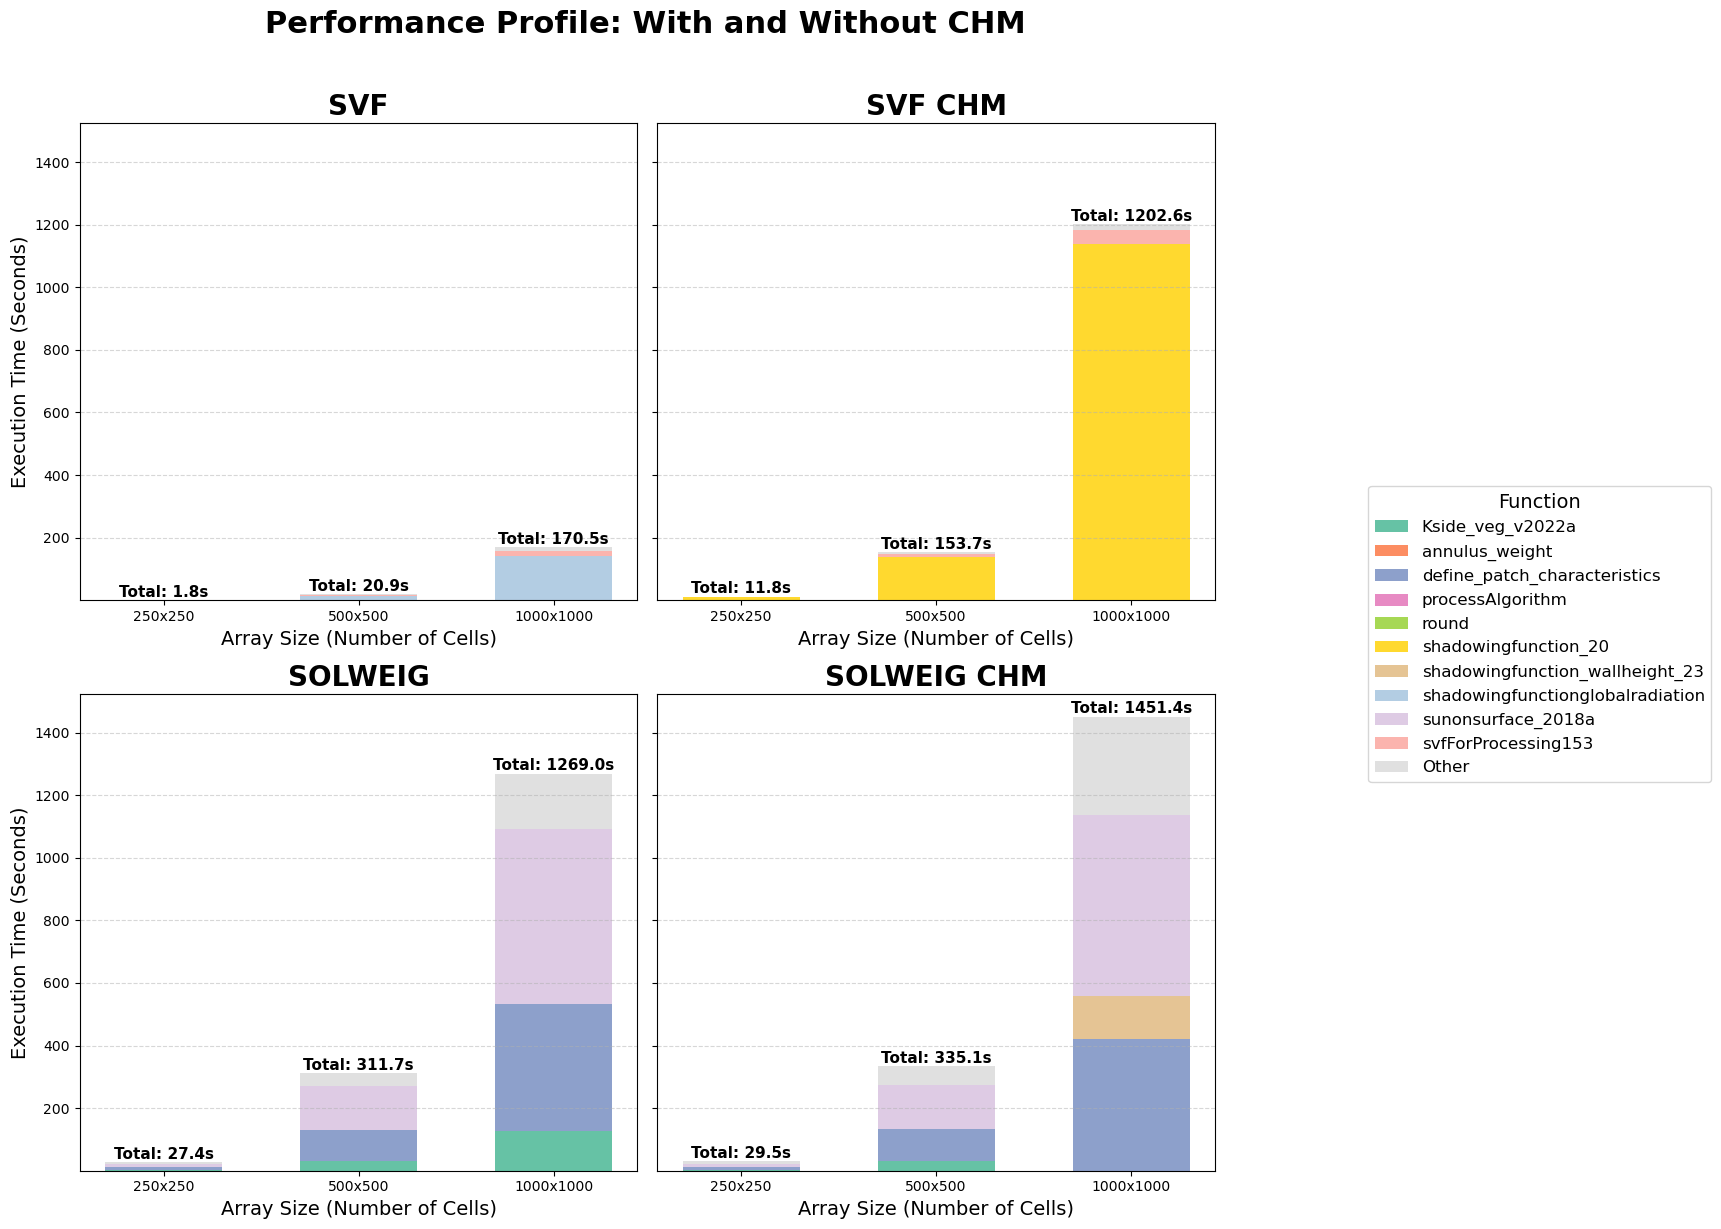

In [12]:
import matplotlib.pyplot as plt
import re
import os
from collections import defaultdict

# Function to process the profile data
def process_profile(files, base_dir):
    """
    Processes profile text files to extract top 3 functions by 'tottime'
    and the total 'cumtime' for each specified file.
    """
    # Regex pattern to extract tottime, cumtime, and function name
    # It handles various formats for the time and function name parts.
    pattern = re.compile(r'\s*\d+[\d/]*\s+(\S+)\s+\S+\s+(\S+)\s+\S+\s+(.+):\d+\((.+)\)')

    top3_times = defaultdict(list) # Stores top 3 functions (tottime, func_name) for each array size
    total_times = {} # Stores total cumtime for each array size

    for label, filename in files.items():
        path = os.path.join(base_dir, filename)
        if not os.path.exists(path):
            print(f"File not found: {path}")
            continue

        # Open file with latin1 encoding as specified in the original code
        with open(path, 'r', encoding='latin1') as f:
            lines = f.readlines()

        data = [] # Temporary list to store (tottime, func_name) for current file
        max_cumtime = 0 # To find the overall cumulative time for the file
        for line in lines:
            match = pattern.match(line)
            if match:
                tottime = float(match.group(1)) # Self time of the function
                cumtime = float(match.group(2)) # Cumulative time of the function
                func_name = match.group(4) # Extracted function name
                data.append((tottime, func_name))
                if cumtime > max_cumtime:
                    max_cumtime = cumtime # Update max_cumtime with the highest cumtime found

        total_times[label] = max_cumtime # Store the total cumulative time

        # Sort functions by tottime in descending order and take the top 3
        top3 = sorted(data, key=lambda x: -x[0])[:3]
        top3_times[label] = top3

    return top3_times, total_times

# --- Data Definition and Processing ---

# Base directory for profile files
base_dir = "D:/Geomatics/optimization_tests_computer/"

# File paths for SOLWEIG data (without and with trees)
solweig_files = {
    "250x250": "250/profile_results_umep.txt",
    "500x500": "500/profile_results_umep.txt",
    "1000x1000": "1000/profile_results_umep.txt",
}

solweig_chm_files = {
    "250x250": "250/profile_results_umep_chm.txt",
    "500x500": "500/profile_results_umep_chm.txt",
    "1000x1000": "1000/profile_results_umep_chm.txt",
}

# File paths for SVF data (without and with trees)
svf_files = {
    "250x250": "250/svf_profile_results_umep.txt",
    "500x500": "500/svf_profile_results_umep.txt",
    "1000x1000": "1000/svf_profile_results_umep.txt",
}

svf_chm_files = {
    "250x250": "250/svf_profile_results_umep_chm.txt",
    "500x500": "500/svf_profile_results_umep_chm.txt",
    "1000x1000": "1000/svf_profile_results_umep_chm.txt",
}

# Process all four datasets
top3_solweig, total_solweig = process_profile(solweig_files, base_dir)
top3_solweig_chm, total_solweig_chm = process_profile(solweig_chm_files, base_dir)
top3_svf, total_svf = process_profile(svf_files, base_dir)
top3_svf_chm, total_svf_chm = process_profile(svf_chm_files, base_dir)

# --- Plotting Configuration ---

# Combine all unique function names from all datasets for consistent coloring
all_funcs_set = set()
for dataset_top3 in [top3_solweig, top3_solweig_chm, top3_svf, top3_svf_chm]:
    for v in dataset_top3.values():
        for _, name in v:
            all_funcs_set.add(name)

all_funcs = sorted(list(all_funcs_set)) # Sort for consistent ordering in legend

# Define a new, prettier custom color palette
custom_colors = [
    '#66c2a5',  # Soft Teal
    '#fc8d62',  # Soft Orange
    '#8da0cb',  # Soft Blue-Purple
    '#e78ac3',  # Soft Pink
    '#a6d854',  # Soft Green
    '#ffd92f',  # Soft Yellow
    '#e5c494',  # Soft Brown
    '#b3cde3',  # Light Blue
    '#decbe4',  # Light Purple
    '#fbb4ae',  # Light Red
    '#fed9a6',  # Light Orange
    '#fddaec',  # Lighter Pink
    '#b4b4b4',  # Medium Light Gray
    '#ffed6f',  # Pale Yellow
    '#a6761d',  # Darker Brown
    '#6a3d9a',  # Dark Purple
    '#cab2d6',  # Lilac
    '#fdbf6f',  # Peach
    '#ff7f00',  # Bright Orange
    '#e31a1c',  # Bright Red
    '#33a02c',  # Bright Green
    '#1f78b4',  # Bright Blue
    '#e0e0e0'   # Light Grey for 'Other'
]

# Map functions to colors
# Use modulo operator to cycle through colors if there are more functions than defined colors
func_colors = {func: custom_colors[i % (len(custom_colors) - 1)] for i, func in enumerate(all_funcs)}
func_colors["Other"] = custom_colors[-1] # Assign the last color to 'Other'

# Prepare datasets for plotting
# Order: SVF, SVF CHM, SOLWEIG, SOLWEIG CHM
plot_data = [
    (top3_svf, total_svf, "SVF"),
    (top3_svf_chm, total_svf_chm, "SVF CHM"),
    (top3_solweig, total_solweig, "SOLWEIG"),
    (top3_solweig_chm, total_solweig_chm, "SOLWEIG CHM"),
]

# --- Create the 2x2 Plot ---

# Create a figure and a 2x2 grid of subplots, sharing the Y-axis for better comparison
# Reduced figure width from 16 to 15, as bar width is also reduced
fig, axs = plt.subplots(2, 2, figsize=(13, 12), sharey=True)
axs = axs.flatten() # Flatten the 2x2 array of axes for easy iteration

# Add the main title to the figure
fig.suptitle("Performance Profile: With and Without CHM", fontsize=22, fontweight='bold', y=1.02) # y adjusts title position

# To track functions already added to the legend (to avoid duplicates)
added_legend_funcs = set()

# Define the bar width
bar_width = 0.6 # Reduced from default 0.8

for i, (top3, total, title) in enumerate(plot_data):
    ax = axs[i] # Get the current subplot axis
    labels = list(top3.keys()) # Array sizes (e.g., "250x250")
    bottoms = [0] * len(labels) # Initialize bottom positions for stacked bars

    # Plot top 3 functions for each array size
    for func in all_funcs: # Iterate through all known functions to ensure consistent order
        values = []
        for label in labels:
            # Find the tottime for the current function in the current array size
            match = next(((time, name) for time, name in top3[label] if name == func), (0, func))
            values.append(match[0]) # Add the tottime (0 if function not in top3)

        # Plot the bar for the current function with specified width
        ax.bar(labels, values, bottom=bottoms, color=func_colors.get(func, 'gray'),
               label=func if func not in added_legend_funcs else "", width=bar_width)

        # Update bottom positions for the next stack
        bottoms = [b + v for b, v in zip(bottoms, values)]

        # Add function to the set of added legend functions
        if func not in added_legend_funcs:
            added_legend_funcs.add(func)

    # Plot "Other" category (total time - sum of top 3)
    other_values = []
    for j, label in enumerate(labels):
        total_time = total[label]
        top3_total = sum(t for t, _ in top3[label])
        other = max(0, total_time - top3_total) # Calculate 'Other' time (ensure non-negative)
        other_values.append(other)

        # Display total time on top of the stacked bar
        ax.text(j, bottoms[j] + other + 0.5, f"Total: {total_time:.1f}s", ha='center', va='bottom', fontsize=11, fontweight='bold')

    # Plot the 'Other' bar with specified width
    ax.bar(labels, other_values, bottom=bottoms, color=func_colors["Other"],
           label="Other" if "Other" not in added_legend_funcs else "", width=bar_width)
    if "Other" not in added_legend_funcs:
        added_legend_funcs.add("Other")


    ax.set_title(title, fontsize=20, fontweight='bold')
    ax.set_xlabel("Array Size (Number of Cells)", fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.5) # Add grid for better readability

# Set common y-axis label for the leftmost plots
axs[0].set_ylabel("Execution Time (Seconds)", fontsize=14)
axs[2].set_ylabel("Execution Time (Seconds)", fontsize=14)


# Create a single legend for the entire figure, placing it outside the plots
# Get handles and labels from one of the axes (e.g., axs[0])
handles, labels = axs[0].get_legend_handles_labels()
# Filter out duplicate labels if any
unique_labels = []
unique_handles = []
for h, l in zip(handles, labels):
    if l not in unique_labels:
        unique_labels.append(l)
        unique_handles.append(h)

fig.legend(unique_handles, unique_labels, title="Function", bbox_to_anchor=(1.05, 0.5), loc="center left", fontsize=12, title_fontsize=14)

plt.tight_layout(rect=[0, 0, 0.95, 1]) # Adjust layout to make space for the legend
plt.show()



C:\Users\jessi\AppData\Local\Temp\ipykernel_29424\4176417874.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2d['total_cells'] = df_2d['cells'] ** 2


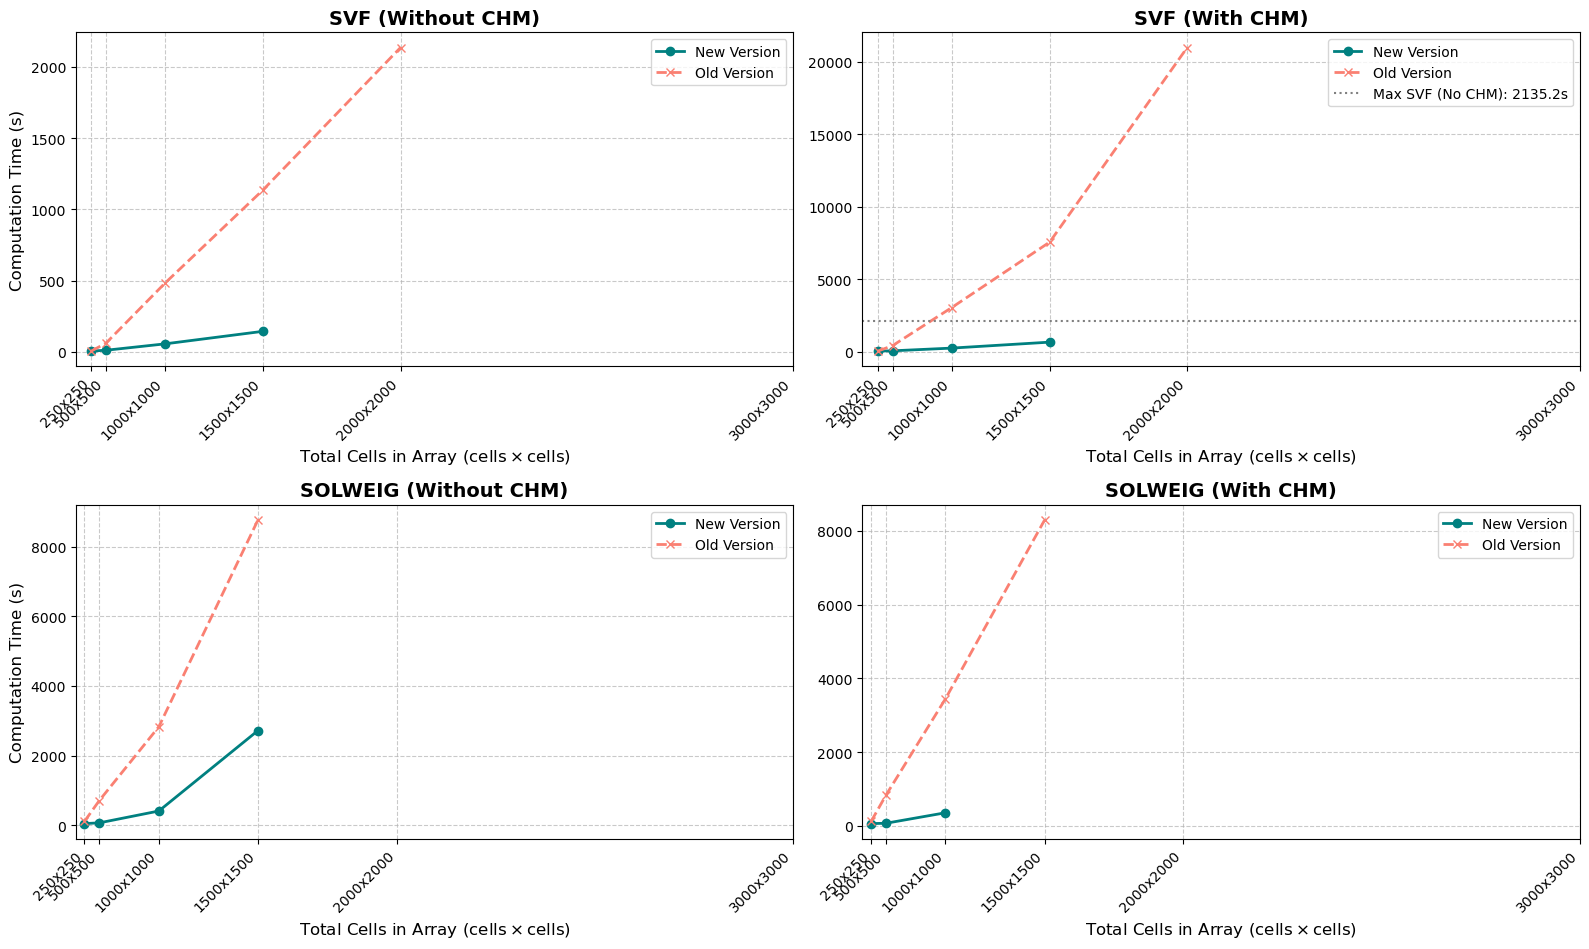

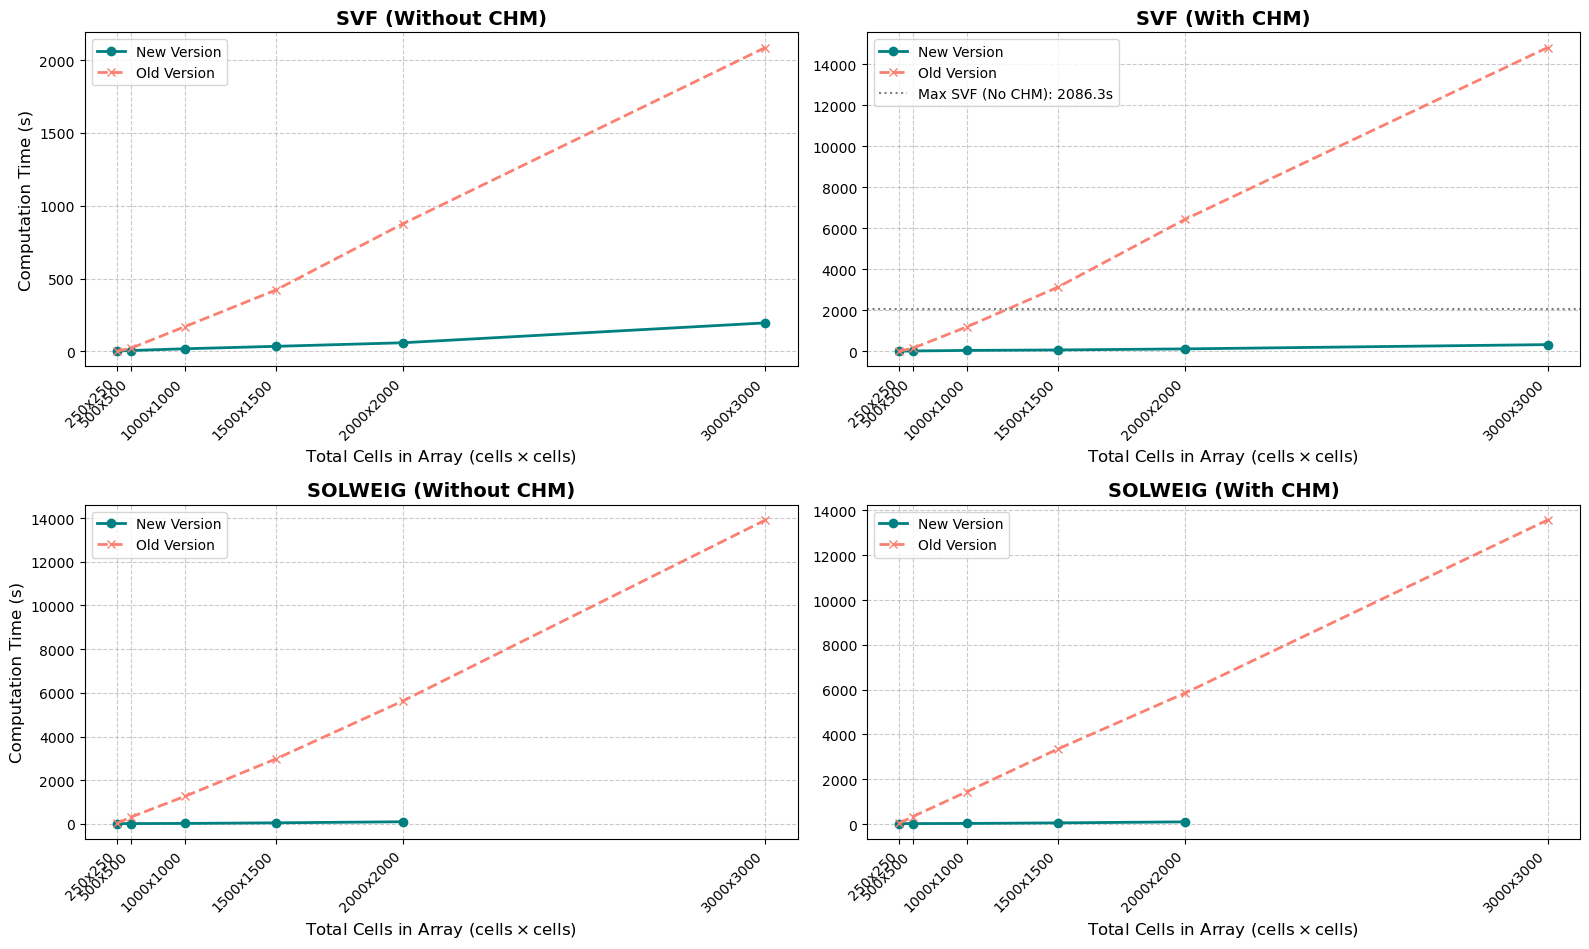

In [6]:
4import pandas as pd
import matplotlib.pyplot as plt
import io

# --- Data Loading ---
# Path to your CSV file. Please update this if your file is named differently or located elsewhere.
csv_file_path = '../../datasets/runtimes.csv'
try:
    # Read the CSV data into a pandas DataFrame, treating 'NULL' as NaN
    df = pd.read_csv(csv_file_path, sep=',', na_values='NULL')

    # Strip whitespace from column names to handle potential hidden spaces
    df.columns = df.columns.str.strip()

except FileNotFoundError:
    print(f"Error: The file '{csv_file_path}' was not found. Please ensure the CSV file is in the correct directory or update the 'csv_file_path' variable.")
    exit() # Exiting for demonstration; in a real app, you might raise an exception or show a user-friendly message


# Filter out columns ending with '_3d' as requested
df_2d = df.loc[:, ~df.columns.str.contains('_3d')]

# Calculate the total number of cells for the x-axis values
df_2d['total_cells'] = df_2d['cells'] ** 2

# Create formatted X-axis labels (e.g., "250x250") from the 'cells' column
x_labels = [f'{c}x{c}' for c in df_2d['cells']]

# Define the types of plots (lap or com) to generate
plot_types = ['lap', 'com']

# Define the calculation types (SVF or SOLWEIG) for rows
calcs = ['svf', 'sol']

# Define the CHM statuses (building only or with CHM) for columns
# 'bud' refers to 'building only' (without CHM), 'chm' refers to 'with CHM'
chm_statuses = ['bud', 'chm']

# Custom titles for each of the 2x2 subplots for better readability
subplot_titles = {
    'svf_bud': 'SVF (Without CHM)',
    'svf_chm': 'SVF (With CHM)',
    'sol_bud': 'SOLWEIG (Without CHM)',
    'sol_chm': 'SOLWEIG (With CHM)'
}

# Iterate through 'lap' and 'com' to create two separate figures
for plot_type in plot_types:
    # Create a 2x2 grid of subplots for the current plot_type (lap or com)
    # sharey=False as we are using a linear scale and ranges might differ significantly
    # Increased figure width to give more space for x-axis labels
    fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharey=False)

    # Iterate through rows (SVF then SOLWEIG)
    for i, calc in enumerate(calcs):
        # Iterate through columns (Without CHM then With CHM)
        for j, chm_status in enumerate(chm_statuses):
            ax = axs[i, j] # Get the current subplot axis

            # Construct the full column names for new and old versions
            col_new = f'{plot_type}_{calc}_{chm_status}_new_2d'
            col_old = f'{plot_type}_{calc}_{chm_status}_old_2d'

            # Plot data for the 'New Version'
            # Use 'total_cells' for the x-axis positions
            ax.plot(df_2d['total_cells'], df_2d[col_new],
                    marker='o', linestyle='-', label='New Version',
                    color='teal', linewidth=2)


            # Plot data for the 'Old Version'
            ax.plot(df_2d['total_cells'], df_2d[col_old],
                    marker='x', linestyle='--', label='Old Version',
                    color='salmon', linewidth=2)

            # --- Add reference line for SVF (Without CHM) max to SVF (With CHM) plot ---
            if calc == 'svf' and chm_status == 'chm':
                # Get max value from SVF (Without CHM) for both new and old versions
                max_svf_bud_new = df_2d[f'{plot_type}_svf_bud_new_2d'].max()
                max_svf_bud_old = df_2d[f'{plot_type}_svf_bud_old_2d'].max()

                # Take the overall maximum between new and old for the reference line
                max_ref_value = max(max_svf_bud_new if pd.notna(max_svf_bud_new) else 0,
                                    max_svf_bud_old if pd.notna(max_svf_bud_old) else 0)

                if max_ref_value > 0: # Only draw if there's a valid max value
                    ax.axhline(y=max_ref_value, color='gray', linestyle=':', linewidth=1.5,
                               label=f'Max SVF (No CHM): {max_ref_value:.1f}s')


            # Set X-axis ticks to match the 'total_cells' values and apply the custom labels
            ax.set_xticks(df_2d['total_cells'])
            ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=10)

            # Set subplot title
            ax.set_title(subplot_titles[f'{calc}_{chm_status}'], fontsize=14, fontweight='bold')

            # Set X-axis label with the new description, using LaTeX for formatting
            ax.set_xlabel('Total Cells in Array ($ \\text{cells} \\times \\text{cells} $)', fontsize=12)

            # Set Y-axis label only for the left-most plots in each row for clarity
            if j == 0:
                ax.set_ylabel('Computation Time (s)', fontsize=12)

            # Add grid for better readability
            ax.grid(True, which="both", ls="--", c='0.7', alpha=0.7)

            # Add legend to each subplot
            ax.legend(fontsize=10)

    # Adjust the layout to prevent titles/labels from overlapping
    # rect=[left, bottom, right, top] controls the normalized figure coordinates for the subplots
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show() # Display the figure


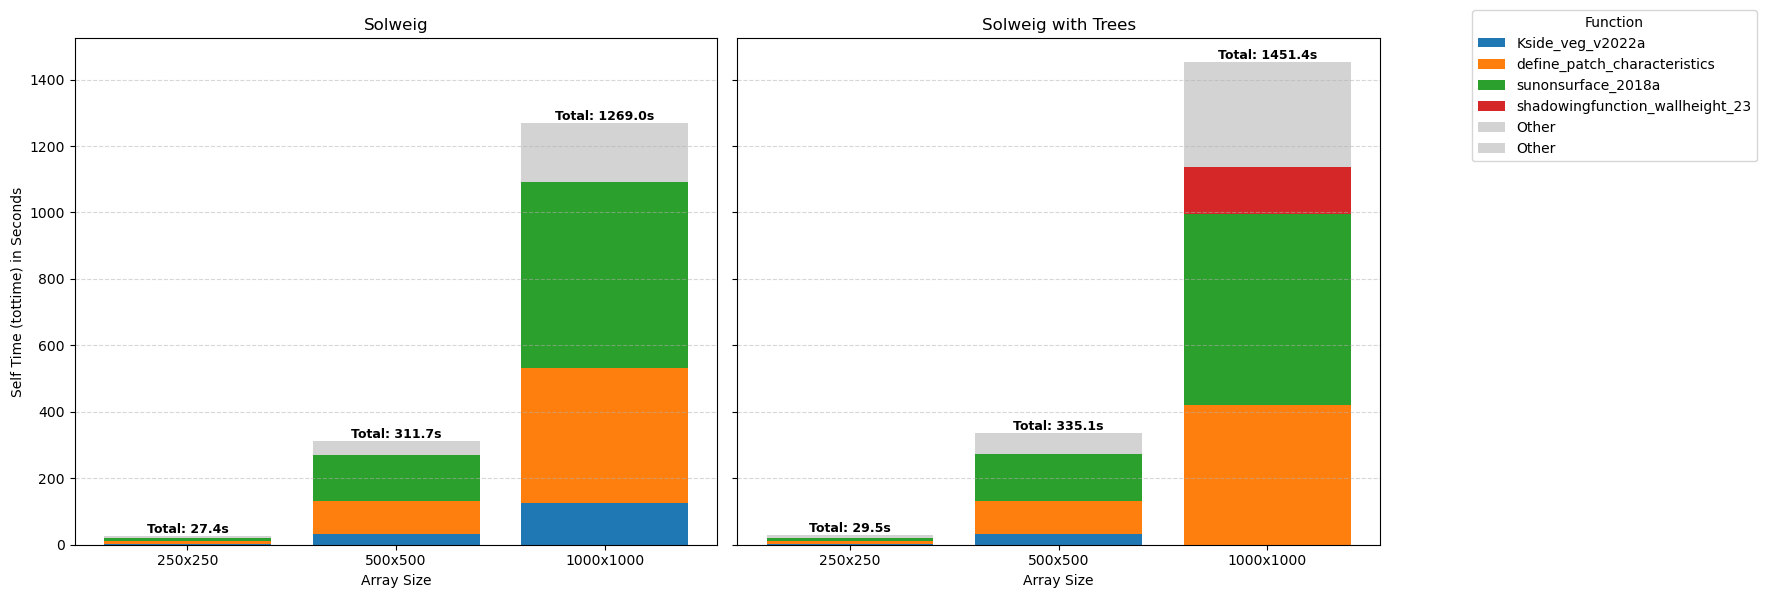

In [1]:
import os
import re
import matplotlib.pyplot as plt
from collections import defaultdict

def process_profile(files, base_dir):
    pattern = re.compile(r'\s*\d+[\d/]*\s+(\S+)\s+\S+\s+(\S+)\s+\S+\s+(.+):\d+\((.+)\)')
    top3_times = defaultdict(list)
    total_times = {}

    for label, filename in files.items():
        path = os.path.join(base_dir, filename)
        if not os.path.exists(path):
            print(f"File not found: {path}")
            continue

        with open(path, 'r', encoding='latin1') as f:
            lines = f.readlines()

        data = []
        max_cumtime = 0
        for line in lines:
            match = pattern.match(line)
            if match:
                tottime = float(match.group(1))
                cumtime = float(match.group(2))
                func_name = match.group(4)
                data.append((tottime, func_name))
                if cumtime > max_cumtime:
                    max_cumtime = cumtime

        total_times[label] = max_cumtime
        top3 = sorted(data, key=lambda x: -x[0])[:3]
        top3_times[label] = top3

    return top3_times, total_times

# Paths and files
base_dir = "D:/Geomatics/optimization_tests_computer/"
files_1 = {
    "250x250": "250/profile_results_umep.txt",
    "500x500": "500/profile_results_umep.txt",
    "1000x1000": "1000/profile_results_umep.txt",
}
files_2 = {
    "250x250": "250/profile_results_umep_chm.txt",
    "500x500": "500/profile_results_umep_chm.txt",
    "1000x1000": "1000/profile_results_umep_chm.txt",
}

# Process both datasets
top3_a, total_a = process_profile(files_1, base_dir)
top3_b, total_b = process_profile(files_2, base_dir)

# Combine all function names to assign consistent colors
all_funcs = {name for v in list(top3_a.values()) + list(top3_b.values()) for _, name in v}
func_colors = dict(zip(all_funcs, plt.cm.tab10.colors[:len(all_funcs)]))
func_colors["Other"] = "lightgrey"

# Prepare subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
titles = ["Solweig", "Solweig with Trees"]
datasets = [(top3_a, total_a), (top3_b, total_b)]

# To track added functions in the legend
added_legend = set()

for ax, (top3, total), title in zip(axs, datasets, titles):
    labels = list(top3.keys())
    bottoms = [0] * len(labels)

    for func in func_colors:
        if func == "Other":
            continue
        values = []
        for label in labels:
            match = next(((time, name) for time, name in top3[label] if name == func), (0, func))
            values.append(match[0])
        ax.bar(labels, values, bottom=bottoms, color=func_colors[func], label=func if func not in added_legend else "")
        bottoms = [b + v for b, v in zip(bottoms, values)]

        # Add function to legend tracking
        if func not in added_legend:
            added_legend.add(func)

    # Add "Other" time
    for i, label in enumerate(labels):
        total_time = total[label]
        top3_total = sum(t for t, _ in top3[label])
        other = max(0, total_time - top3_total)
        ax.bar(label, other, bottom=bottoms[i], color="lightgrey", label="Other" if i == 0 else "")
        ax.text(i, bottoms[i] + other + 0.5, f"Total: {total_time:.1f}s", ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax.set_title(title)
    ax.set_xlabel("Array Size ")
    ax.grid(axis='y', linestyle='--', alpha=0.5)

axs[0].set_ylabel("Excexution Time in Seconds")
fig.legend(title="Function", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()



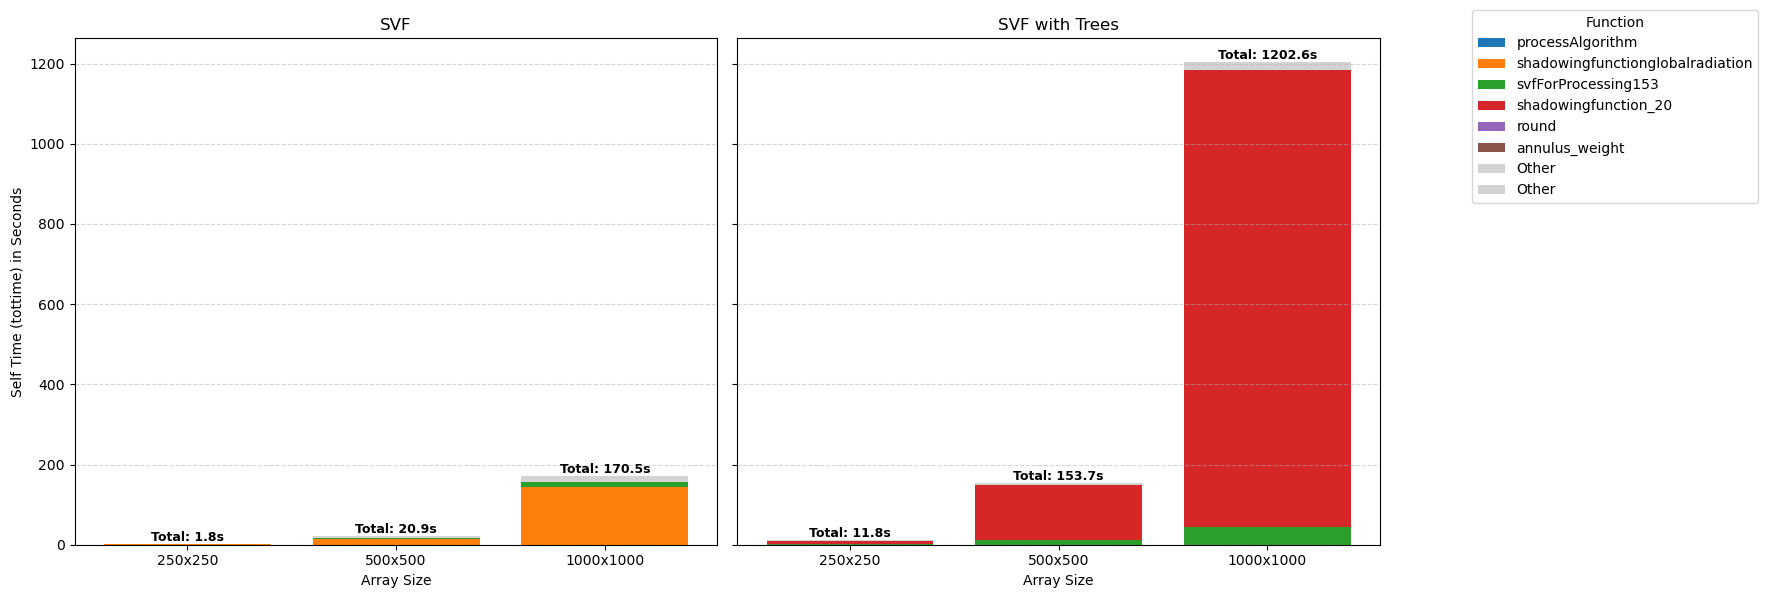

In [14]:
base_dir = "D:/Geomatics/optimization_tests_computer/"
files_1 = {
    "250x250": "250/svf_profile_results_umep.txt",
    "500x500": "500/svf_profile_results_umep.txt",
    "1000x1000": "1000/svf_profile_results_umep.txt",
}
files_2 = {
    "250x250": "250/svf_profile_results_umep_chm.txt",
    "500x500": "500/svf_profile_results_umep_chm.txt",
    "1000x1000": "1000/svf_profile_results_umep_chm.txt",
}

# Process both datasets
top3_a, total_a = process_profile(files_1, base_dir)
top3_b, total_b = process_profile(files_2, base_dir)

# Combine all function names to assign consistent colors
all_funcs = {name for v in list(top3_a.values()) + list(top3_b.values()) for _, name in v}
func_colors = dict(zip(all_funcs, plt.cm.tab10.colors[:len(all_funcs)]))
func_colors["Other"] = "lightgrey"

# Prepare subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
titles = ["SVF", "SVF with Trees"]
datasets = [(top3_a, total_a), (top3_b, total_b)]

# To track added functions in the legend
added_legend = set()

for ax, (top3, total), title in zip(axs, datasets, titles):
    labels = list(top3.keys())
    bottoms = [0] * len(labels)

    for func in func_colors:
        if func == "Other":
            continue
        values = []
        for label in labels:
            match = next(((time, name) for time, name in top3[label] if name == func), (0, func))
            values.append(match[0])
        ax.bar(labels, values, bottom=bottoms, color=func_colors[func], label=func if func not in added_legend else "")
        bottoms = [b + v for b, v in zip(bottoms, values)]

        # Add function to legend tracking
        if func not in added_legend:
            added_legend.add(func)

    # Add "Other" time
    for i, label in enumerate(labels):
        total_time = total[label]
        top3_total = sum(t for t, _ in top3[label])
        other = max(0, total_time - top3_total)
        ax.bar(label, other, bottom=bottoms[i], color="lightgrey", label="Other" if i == 0 else "")
        ax.text(i, bottoms[i] + other + 0.5, f"Total: {total_time:.1f}s", ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax.set_title(title)
    ax.set_xlabel("Array Size")
    ax.grid(axis='y', linestyle='--', alpha=0.5)

axs[0].set_ylabel("Self Time (tottime) in Seconds")
fig.legend(title="Function", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

File not found: D:/Geomatics/optimization_tests_computer/250/profile_results_umep.txt
File not found: D:/Geomatics/optimization_tests_computer/500/profile_results_umep.txt
File not found: D:/Geomatics/optimization_tests_computer/1000/profile_results_umep.txt
File not found: D:/Geomatics/optimization_tests_computer/1500/profile_results_umep.txt
File not found: D:/Geomatics/optimization_tests_computer/2000/profile_results_umep.txt
File not found: D:/Geomatics/optimization_tests_computer/3000/profile_results_umep.txt
File not found: D:/Geomatics/optimization_tests_computer/250/profile_results_cupy.txt
File not found: D:/Geomatics/optimization_tests_computer/500/profile_results_cupy.txt
File not found: D:/Geomatics/optimization_tests_computer/1000/profile_results_cupy.txt
File not found: D:/Geomatics/optimization_tests_computer/1500/profile_results_cupy.txt
File not found: D:/Geomatics/optimization_tests_computer/2000/profile_results_cupy.txt
File not found: D:/Geomatics/optimization_tests

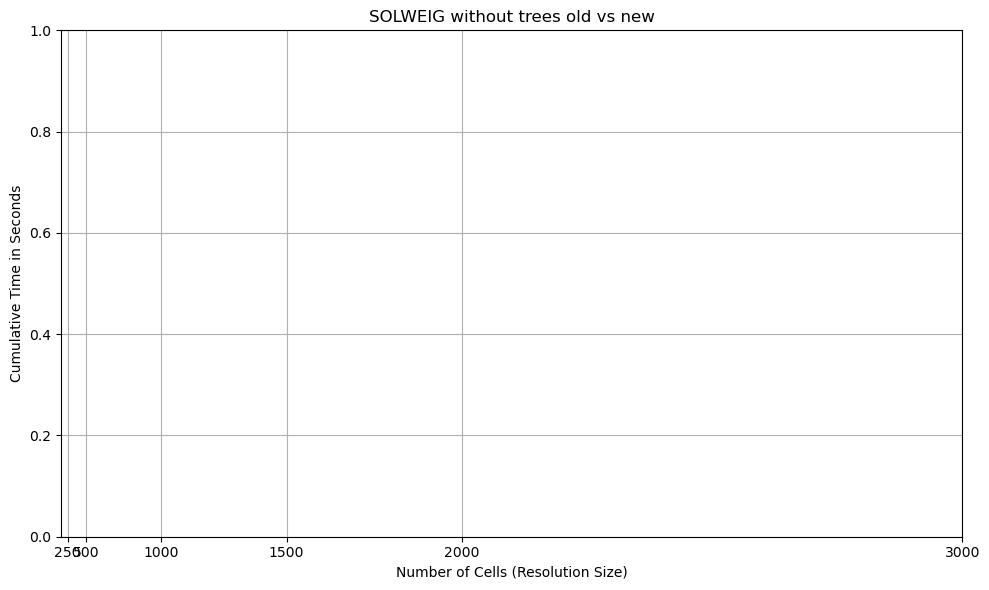

In [5]:
import os
import re
import matplotlib.pyplot as plt
from collections import defaultdict
import itertools

# Function to process each version's data from the profile files
def process_version_files(files_by_version, base_dir):
    pattern = re.compile(r'\s*\d+[\d/]*\s+(\S+)\s+\S+\s+(\S+)\s+\S+\s+(.+):\d+\((.+)\)')
    version_times = defaultdict(dict)  # Store times for each version and resolution

    for version, files in files_by_version.items():
        for filename in files:
            path = os.path.join(base_dir, filename)
            if not os.path.exists(path):
                print(f"File not found: {path}")
                continue

            with open(path, 'r', encoding='latin1') as f:
                lines = f.readlines()

            for line in lines:
                match = pattern.match(line)
                if match:
                    cumtime = float(match.group(2))
                    func_name = match.group(4)
                    resolution = filename.split('/')[0]  # Get resolution from the filename (e.g., '250')

                    # Keep track of the maximum cumtime for the current resolution and version
                    if resolution not in version_times[version]:
                        version_times[version][resolution] = cumtime
                    else:
                        version_times[version][resolution] = max(version_times[version][resolution], cumtime)

    return version_times


# Define the versions and corresponding files
base_dir = "D:/Geomatics/optimization_tests_computer/"

files_by_version = {
    "Version 1": [
        "250/profile_results_umep.txt",
        "500/profile_results_umep.txt",
        "1000/profile_results_umep.txt",
        "1500/profile_results_umep.txt",
        "2000/profile_results_umep.txt",
        "3000/profile_results_umep.txt"
    ],
    "Version 2": [
        "250/profile_results_cupy.txt",
        "500/profile_results_cupy.txt",
        "1000/profile_results_cupy.txt",
        "1500/profile_results_cupy.txt",
        "2000/profile_results_cupy.txt",
        "3000/profile_results_cupy.txt"
    ]
}

# Process data
version_times = process_version_files(files_by_version, base_dir)

# Number of cells for each resolution
cell_counts = {
    "250": 250 * 250,
    "500": 500 * 500,
    "1000": 1000 * 1000,
    "1500": 1500 * 1500,
    "2000": 2000 * 2000,
    "3000": 3000 * 3000,
}

# Plot setup
plt.figure(figsize=(10, 6))

version_colors = {
    "Version 1": "blue",
    "Version 2": "green"
}

# Plotting the cumtimes for each version with fixed colors
for version, times in version_times.items():
    color = version_colors.get(version, 'black')  # Default to black if version not found
    for resolution, cumtime in times.items():
        if resolution in cell_counts:
            num_cells = cell_counts[resolution]
            plt.scatter(num_cells, cumtime, label=f"{version} - {resolution}x{resolution}",
                        s=10, color=color, marker='o')

# Customize plot
plt.xlabel('Number of Cells (Resolution Size)')
plt.ylabel('Cumulative Time in Seconds')
plt.title('SOLWEIG without trees old vs new')
plt.grid(True)

# Add annotations for the points
for version, times in version_times.items():
    for resolution, cumtime in times.items():
        if resolution in cell_counts:
            num_cells = cell_counts[resolution]
            plt.text(num_cells, cumtime, f"{cumtime:.2f}s", fontsize=10, ha='center', va='bottom')

# Adjust x-ticks to match the resolutions
plt.xticks(list(cell_counts.values()), list(cell_counts.keys()))

# Show plot
plt.tight_layout()
plt.show()

File not found: D:/Geomatics/optimization_tests_computer/3000/profile_results_cupy_chm.txt


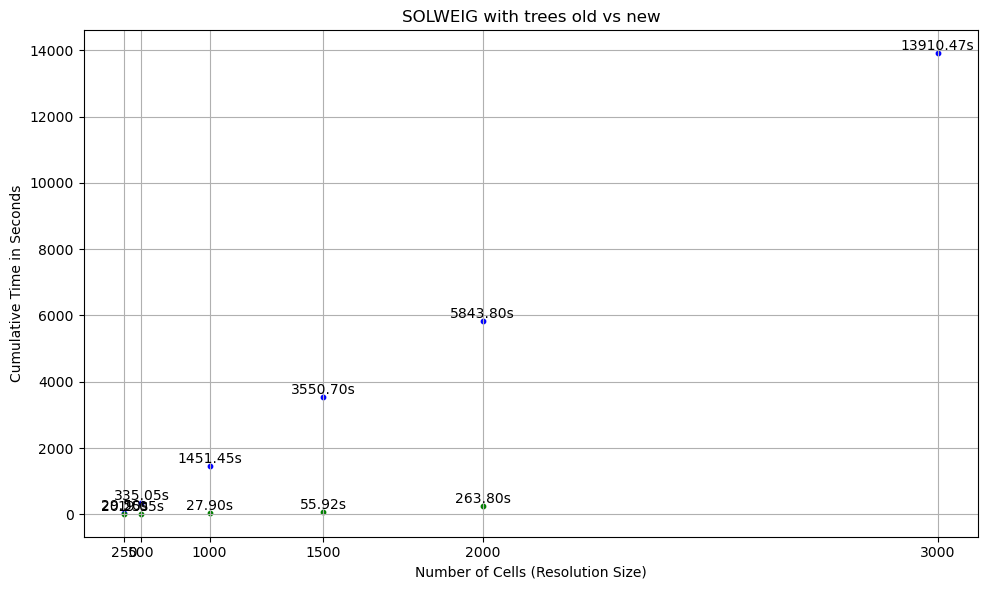

In [26]:
# Define the versions and corresponding files
base_dir = "D:/Geomatics/optimization_tests_computer/"

version1 = 'profile_results_umep_chm.txt'
version2 = 'profile_results_cupy_chm.txt'

files_by_version = {
    "Version 1": [
        f"250/{version1}",
        f"500/{version1}",
        f"1000/{version1}",
        f"1500/{version1}",
        f"2000/{version1}",
        f"3000/{version1}"
    ],
    "Version 2": [
        f"250/{version2}",
        f"500/{version2}",
        f"1000/{version2}",
        f"1500/{version2}",
        f"2000/{version2}",
        f"3000/{version2}"
    ]
}

# Process data
version_times = process_version_files(files_by_version, base_dir)

# Number of cells for each resolution
cell_counts = {
    "250": 250 * 250,
    "500": 500 * 500,
    "1000": 1000 * 1000,
    "1500": 1500 * 1500,
    "2000": 2000 * 2000,
    "3000": 3000 * 3000,
}

# Plot setup
plt.figure(figsize=(10, 6))

version_colors = {
    "Version 1": "blue",
    "Version 2": "green"
}

# Plotting the cumtimes for each version with fixed colors
for version, times in version_times.items():
    color = version_colors.get(version, 'black')  # Default to black if version not found
    for resolution, cumtime in times.items():
        if resolution in cell_counts:
            num_cells = cell_counts[resolution]
            plt.scatter(num_cells, cumtime, label=f"{version} - {resolution}x{resolution}",
                        s=10, color=color, marker='o')

# Customize plot
plt.xlabel('Number of Cells (Resolution Size)')
plt.ylabel('Cumulative Time in Seconds')
plt.title('SOLWEIG with trees old vs new')
plt.grid(True)

# Add annotations for the points
for version, times in version_times.items():
    for resolution, cumtime in times.items():
        if resolution in cell_counts:
            num_cells = cell_counts[resolution]
            plt.text(num_cells, cumtime, f"{cumtime:.2f}s", fontsize=10, ha='center', va='bottom')

# Adjust x-ticks to match the resolutions
plt.xticks(list(cell_counts.values()), list(cell_counts.keys()))

# Show plot
plt.tight_layout()
plt.show()

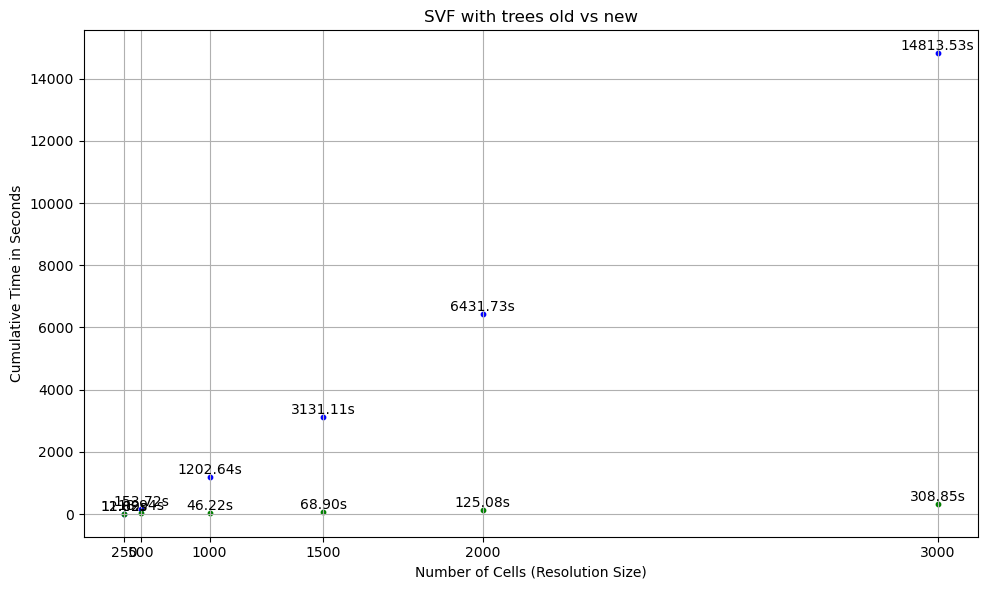

In [27]:
# Define the versions and corresponding files
base_dir = "D:/Geomatics/optimization_tests_computer/"

version1 = 'svf_profile_results_umep_chm.txt'
version2 = 'svf_profile_results_new_chm.txt'

files_by_version = {
    "Version 1": [
        f"250/{version1}",
        f"500/{version1}",
        f"1000/{version1}",
        f"1500/{version1}",
        f"2000/{version1}",
        f"3000/{version1}"
    ],
    "Version 2": [
        f"250/{version2}",
        f"500/{version2}",
        f"1000/{version2}",
        f"1500/{version2}",
        f"2000/{version2}",
        f"3000/{version2}"
    ]
}

# Process data
version_times = process_version_files(files_by_version, base_dir)

# Number of cells for each resolution
cell_counts = {
    "250": 250 * 250,
    "500": 500 * 500,
    "1000": 1000 * 1000,
    "1500": 1500 * 1500,
    "2000": 2000 * 2000,
    "3000": 3000 * 3000,
}

# Plot setup
plt.figure(figsize=(10, 6))

version_colors = {
    "Version 1": "blue",
    "Version 2": "green"
}

# Plotting the cumtimes for each version with fixed colors
for version, times in version_times.items():
    color = version_colors.get(version, 'black')  # Default to black if version not found
    for resolution, cumtime in times.items():
        if resolution in cell_counts:
            num_cells = cell_counts[resolution]
            plt.scatter(num_cells, cumtime, label=f"{version} - {resolution}x{resolution}",
                        s=10, color=color, marker='o')

# Customize plot
plt.xlabel('Number of Cells (Resolution Size)')
plt.ylabel('Cumulative Time in Seconds')
plt.title('SVF with trees old vs new')
plt.grid(True)

# Add annotations for the points
for version, times in version_times.items():
    for resolution, cumtime in times.items():
        if resolution in cell_counts:
            num_cells = cell_counts[resolution]
            plt.text(num_cells, cumtime, f"{cumtime:.2f}s", fontsize=10, ha='center', va='bottom')

# Adjust x-ticks to match the resolutions
plt.xticks(list(cell_counts.values()), list(cell_counts.keys()))

# Show plot
plt.tight_layout()
plt.show()

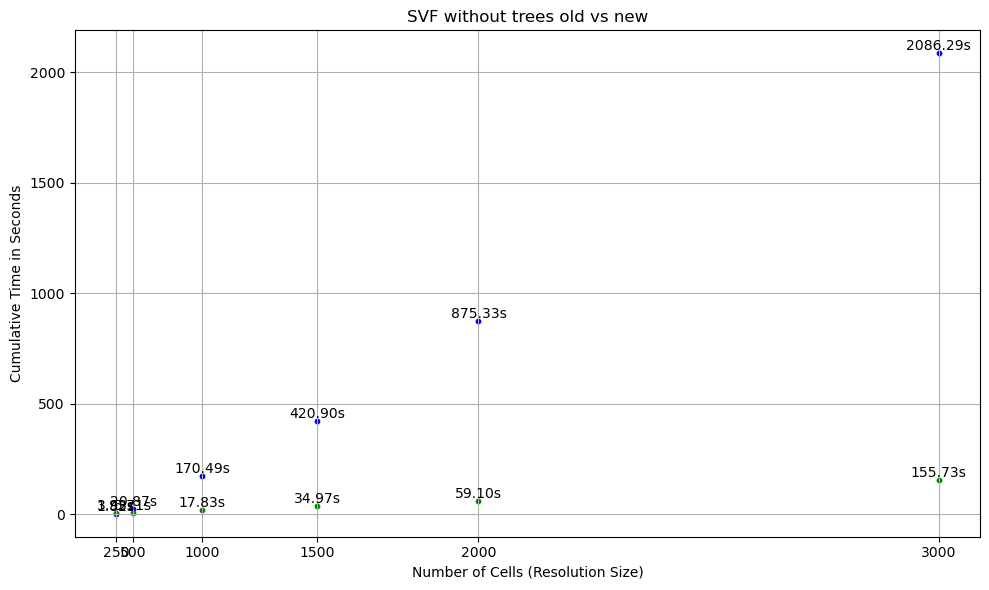

In [28]:
base_dir = "D:/Geomatics/optimization_tests_computer/"

version1 = 'svf_profile_results_umep.txt'
version2 = 'svf_profile_results_new.txt'

files_by_version = {
    "Version 1": [
        f"250/{version1}",
        f"500/{version1}",
        f"1000/{version1}",
        f"1500/{version1}",
        f"2000/{version1}",
        f"3000/{version1}"
    ],
    "Version 2": [
        f"250/{version2}",
        f"500/{version2}",
        f"1000/{version2}",
        f"1500/{version2}",
        f"2000/{version2}",
        f"3000/{version2}"
    ]
}

# Process data
version_times = process_version_files(files_by_version, base_dir)

# Number of cells for each resolution
cell_counts = {
    "250": 250 * 250,
    "500": 500 * 500,
    "1000": 1000 * 1000,
    "1500": 1500 * 1500,
    "2000": 2000 * 2000,
    "3000": 3000 * 3000,
}

# Plot setup
plt.figure(figsize=(10, 6))

version_colors = {
    "Version 1": "blue",
    "Version 2": "green"
}

# Plotting the cumtimes for each version with fixed colors
for version, times in version_times.items():
    color = version_colors.get(version, 'black')  # Default to black if version not found
    for resolution, cumtime in times.items():
        if resolution in cell_counts:
            num_cells = cell_counts[resolution]
            plt.scatter(num_cells, cumtime, label=f"{version} - {resolution}x{resolution}",
                        s=10, color=color, marker='o')

# Customize plot
plt.xlabel('Number of Cells (Resolution Size)')
plt.ylabel('Cumulative Time in Seconds')
plt.title('SVF without trees old vs new')
plt.grid(True)

# Add annotations for the points
for version, times in version_times.items():
    for resolution, cumtime in times.items():
        if resolution in cell_counts:
            num_cells = cell_counts[resolution]
            plt.text(num_cells, cumtime, f"{cumtime:.2f}s", fontsize=10, ha='center', va='bottom')

# Adjust x-ticks to match the resolutions
plt.xticks(list(cell_counts.values()), list(cell_counts.keys()))

# Show plot
plt.tight_layout()
plt.show()

# LAPTOP


File not found: E:/Geomatics/optimization_tests_laptop/2000/svf_profile_results_new_nc.txt
File not found: E:/Geomatics/optimization_tests_laptop/3000/svf_profile_results_new_nc.txt


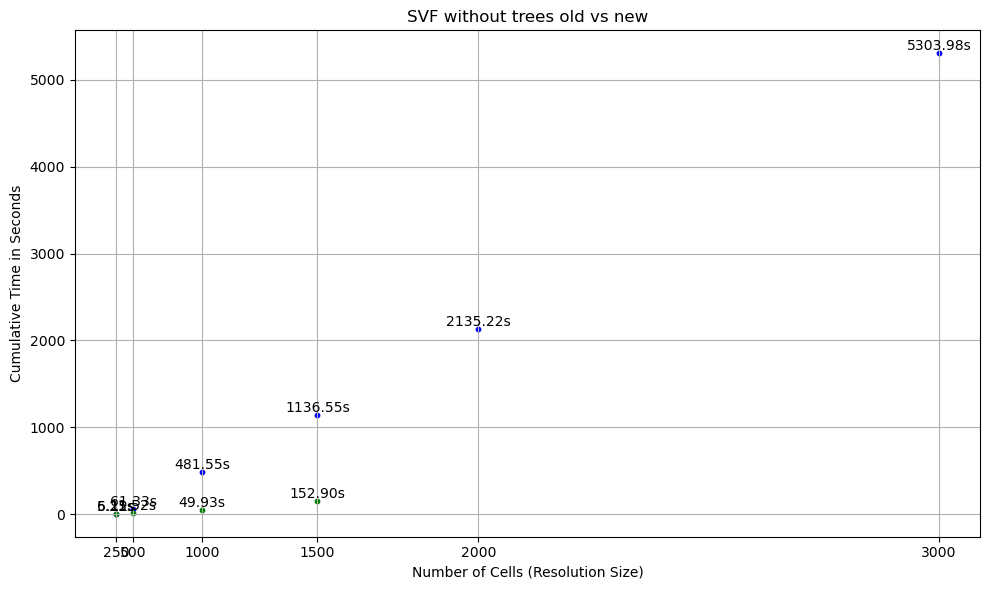

In [7]:
base_dir = "E:/Geomatics/optimization_tests_laptop/"

version1 = 'svf_profile_results_umep.txt'
version2 = 'svf_profile_results_new_nc.txt'

files_by_version = {
    "Version 1": [
        f"250/{version1}",
        f"500/{version1}",
        f"1000/{version1}",
        f"1500/{version1}",
        f"2000/{version1}",
        f"3000/{version1}"
    ],
    "Version 2": [
        f"250/{version2}",
        f"500/{version2}",
        f"1000/{version2}",
        f"1500/{version2}",
        f"2000/{version2}",
        f"3000/{version2}"
    ]
}

# Process data
version_times = process_version_files(files_by_version, base_dir)

# Number of cells for each resolution
cell_counts = {
    "250": 250 * 250,
    "500": 500 * 500,
    "1000": 1000 * 1000,
    "1500": 1500 * 1500,
    "2000": 2000 * 2000,
    "3000": 3000 * 3000,
}

# Plot setup
plt.figure(figsize=(10, 6))

version_colors = {
    "Version 1": "blue",
    "Version 2": "green"
}

# Plotting the cumtimes for each version with fixed colors
for version, times in version_times.items():
    color = version_colors.get(version, 'black')  # Default to black if version not found
    for resolution, cumtime in times.items():
        if resolution in cell_counts:
            num_cells = cell_counts[resolution]
            plt.scatter(num_cells, cumtime, label=f"{version} - {resolution}x{resolution}",
                        s=10, color=color, marker='o')

# Customize plot
plt.xlabel('Number of Cells (Resolution Size)')
plt.ylabel('Cumulative Time in Seconds')
plt.title('SVF without trees old vs new')
plt.grid(True)

# Add annotations for the points
for version, times in version_times.items():
    for resolution, cumtime in times.items():
        if resolution in cell_counts:
            num_cells = cell_counts[resolution]
            plt.text(num_cells, cumtime, f"{cumtime:.2f}s", fontsize=10, ha='center', va='bottom')

# Adjust x-ticks to match the resolutions
plt.xticks(list(cell_counts.values()), list(cell_counts.keys()))

# Show plot
plt.tight_layout()
plt.show()

File not found: E:/Geomatics/optimization_tests_laptop/3000/svf_profile_results_umep_chm.txt
File not found: E:/Geomatics/optimization_tests_laptop/2000/svf_profile_results_new_chm_nc.txt
File not found: E:/Geomatics/optimization_tests_laptop/3000/svf_profile_results_new_chm_nc.txt


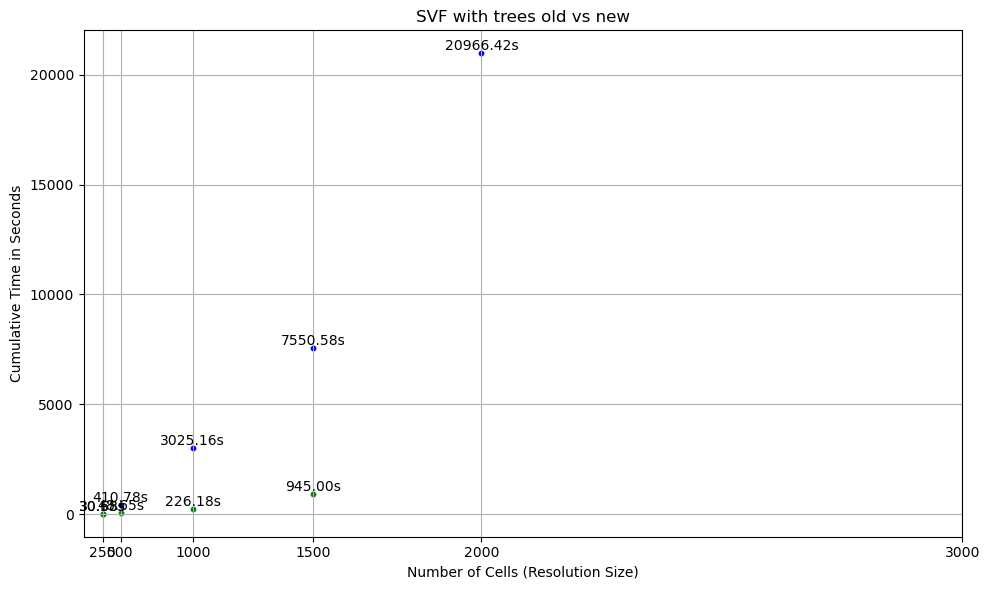

In [8]:
base_dir = "E:/Geomatics/optimization_tests_laptop/"

version1 = 'svf_profile_results_umep_chm.txt'
version2 = 'svf_profile_results_new_chm_nc.txt'

files_by_version = {
    "Version 1": [
        f"250/{version1}",
        f"500/{version1}",
        f"1000/{version1}",
        f"1500/{version1}",
        f"2000/{version1}",
        f"3000/{version1}"
    ],
    "Version 2": [
        f"250/{version2}",
        f"500/{version2}",
        f"1000/{version2}",
        f"1500/{version2}",
        f"2000/{version2}",
        f"3000/{version2}"
    ]
}

# Process data
version_times = process_version_files(files_by_version, base_dir)

# Number of cells for each resolution
cell_counts = {
    "250": 250 * 250,
    "500": 500 * 500,
    "1000": 1000 * 1000,
    "1500": 1500 * 1500,
    "2000": 2000 * 2000,
    "3000": 3000 * 3000,
}

# Plot setup
plt.figure(figsize=(10, 6))

version_colors = {
    "Version 1": "blue",
    "Version 2": "green"
}

# Plotting the cumtimes for each version with fixed colors
for version, times in version_times.items():
    color = version_colors.get(version, 'black')  # Default to black if version not found
    for resolution, cumtime in times.items():
        if resolution in cell_counts:
            num_cells = cell_counts[resolution]
            plt.scatter(num_cells, cumtime, label=f"{version} - {resolution}x{resolution}",
                        s=10, color=color, marker='o')

# Customize plot
plt.xlabel('Number of Cells (Resolution Size)')
plt.ylabel('Cumulative Time in Seconds')
plt.title('SVF with trees old vs new')
plt.grid(True)

# Add annotations for the points
for version, times in version_times.items():
    for resolution, cumtime in times.items():
        if resolution in cell_counts:
            num_cells = cell_counts[resolution]
            plt.text(num_cells, cumtime, f"{cumtime:.2f}s", fontsize=10, ha='center', va='bottom')

# Adjust x-ticks to match the resolutions
plt.xticks(list(cell_counts.values()), list(cell_counts.keys()))

# Show plot
plt.tight_layout()
plt.show()